In [1]:
import yaml
from dataclasses import dataclass
import os 
import numpy as np
import healpy as hp

import costi
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from costi import (
    Configs,
    get_params,
    component_separation,_get_data_simulations_, _get_noise_simulation, _get_cmb_simulation, _get_data_foregrounds_)
from costi.routines import _EB_to_QU, _get_needlet_windows_
from costi._seds import _get_CMB_SED
%matplotlib inline

## Perform run from configuration file

In [2]:
config_path = os.getcwd() + "/configs/config_npipe.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)

Loaded configuration from
 /pscratch/sd/c/carones/SO_extended/configs/config_npipe.yaml


In [3]:
foregrounds = _get_data_foregrounds_(config)

In [4]:
print(foregrounds.shape)  #Nfreqs, Nstokes, Npix, 1 (or >1 if return_fgd_components>1)

(7, 3, 196608, 1)


In [5]:
data = []
noise = []
cmb = []
for nsim in range(config.nsim_start, config.nsim_start+config.nsims):
    data_, cmb_, noise_ = _get_data_simulations_(config, foregrounds[...,0], nsim=nsim)
    data.append(data_)
    noise.append(noise_)
    cmb.append(cmb_)
data = np.array(data)
noise = np.array(noise)
cmb = np.array(cmb)
data = data[...,None]
noise = noise[...,None]

/pscratch/sd/c/carones/SO_extended/costi/simulations.py:140: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  alm_noise = hp.synalm(N_ell, lmax=3*nside-1, new=True, verbose=False)
/pscratch/sd/c/carones/SO_extended/costi/simulations.py:186: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_alms = hp.synalm(cls_cmb, lmax=lmax, new=new, verbose=False)


In [6]:
print(data.shape) # Nsims, Nfreqs, Nstokes, Npix, 1

(1, 7, 3, 196608, 1)


In [7]:
config.field_in = "QU"
config.field_out = "EB"

for idx, nsim in enumerate(range(config.nsim_start, config.nsim_start+config.nsims)):
    combined_data = np.concatenate([data[idx], noise[idx], foregrounds], axis=3)
    component_separation(config, combined_data[:,1:], nsim=nsim)

/pscratch/sd/c/carones/SO_extended/costi/routines.py:459: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  stat_out = hp.alm2map(alm_s, nside_covar, lmax=lmax_stat, verbose=False)
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


## Playing with needlets (items to include in compsep dictionary)

In [10]:
lmax = 256
ell = np.arange(lmax+1)

(2.0, 256.0)

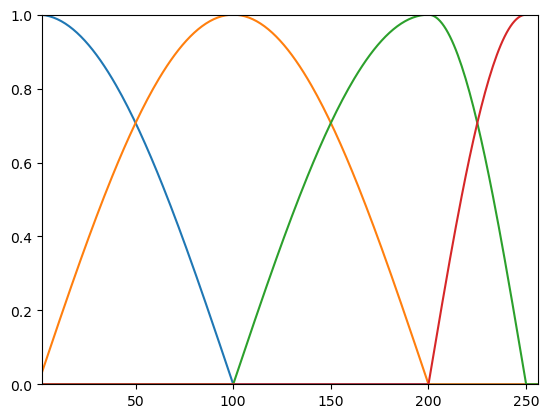

In [17]:
# Cosine needlets
needlet_config = {}
needlet_config["needlet_windows"] = "cosine"
needlet_config["ell_peaks"] = [0,100,200,250]
bl = _get_needlet_windows_(needlet_config, lmax)

plt.figure()
plt.plot(ell,bl.T)
plt.ylim(0.,1.)
plt.xlim(2,lmax)
# plt.xscale("log")

(2.0, 256.0)

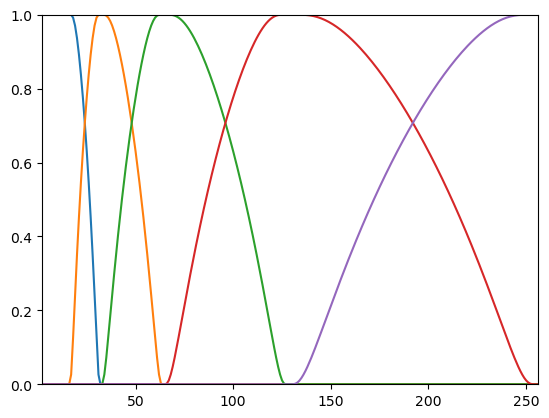

In [21]:
# Standard needlets
needlet_config = {}
needlet_config["needlet_windows"] = "standard"
needlet_config["width"] = 2.
#  Here it will merge all needlets between a needlet scale and the other included in the list
needlet_config["merging_needlets"] = [0, 5] # [0, 5, 7, 9] #
bl = _get_needlet_windows_(needlet_config, lmax)

plt.figure()
plt.plot(ell,bl.T)
plt.ylim(0.,1.)
plt.xlim(2,lmax)

(2.0, 256.0)

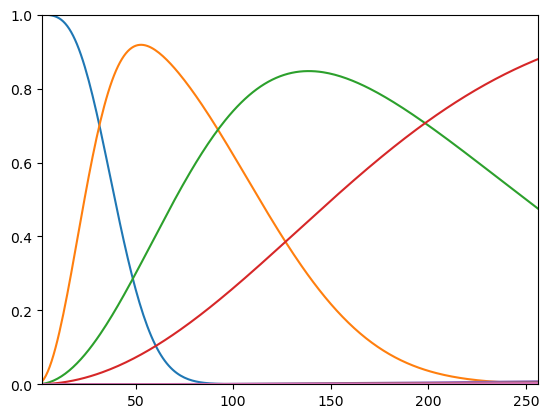

In [23]:
# Mexican needlets
needlet_config = {}
needlet_config["needlet_windows"] = "mexican"
needlet_config["width"] = 1.3
#  Here it will merge all needlets between a needlet scale and the other included in the list
needlet_config["merging_needlets"] = [0, 13, 17, 20, 30] # 
bl = _get_needlet_windows_(needlet_config, lmax)

plt.figure()
plt.plot(ell,bl.T)
plt.ylim(0.,1.)
plt.xlim(2,lmax)